# Cat vs. Dog (Binary Classification) with N11 Model 

## Background
Binary classification in the context of images, is the process of teaching a model to categorize a given image into one of two possible classes. 
We need to classify images to automate tasks that require visual understanding, enabling computers to interpret and make decisions based on the content of a picture.
This ability to automatically categorize images unlocks countless applications across various industries, from healthcare to transportation.

- Classify a skin lesion as either benign or malignant (cancerous) from a photograph, assisting dermatologists in early cancer detection. 
- An autonomous vehicle needs to classify objects as pedestrians or other objects.
- Classify different types of crops from an aerial photo, assess plant health by identifying diseased vs. healthy crops.
- Unlock your smartphone with your face is a process to identify authorized personnel vs. unauthorized intruders.

## Objectives:
- Practice neural network model with a hidden layer.
- Review binary classification.
- Get started using [PyTorch](https://pytorch.org/).

## Exercises:
1. $\color{violet}{\textbf{(20\%) Data Preprocessing}}$
2. $\color{violet}{\textbf{(5\%) Logistic Regression Model}}$
3. $\color{violet}{\textbf{(5\%) Cross Entropy Loss}}$
4. $\color{violet}{\textbf{(40\%) Gradient Descent Optimization}}$
5. $\color{violet}{\textbf{(20\%) Evaluation on Test Dataset}}$
6. $\color{violet}{\textbf{(10\%) Test Model with New Image}}$




## 1. Dataset Preparation with PyTorch

### 1.1 Create Annotation Files
Data is not always stored in NumPy arrays. Most cases, you will have to organize and annotate the raw data stored in your hard drive. For image data, you want it to be organized as the following way.
``` console
root/dog/xxx.jpg
root/dog/xxy.jpg
root/dog/xxz.jpg

root/cat/123.jpg
root/cat/456.jpg
root/cat/789.jpg
```
To grab image information and store them in an comma-seperated values (CSV) file:
1. Visit the data directory, grab all images' paths and corresponding categories.
2. Save the paths and categories of images in an `.csv` file 

In [62]:
import os
from glob import glob
import pandas as pd
from pathlib import Path

# Locate train and validation directories
root_dir = "./dataset"  # locate dataset directory from this repo in the whole system
train_cat_dir = Path(root_dir) / "training" / "cats"
train_dog_dir = Path(root_dir) / "training" / "dogs"
val_cat_dir = Path(root_dir) / "validation" / "cats"
val_dog_dir = Path(root_dir) / "validation" / "dogs"

# Glob training files
train_cat_files = list(train_cat_dir.glob("**/*.jpg"))
train_dog_files = list(train_dog_dir.glob("**/*.jpg"))
print(f"There are {len(train_cat_files)} cat images, and {len(train_dog_files)} dog images in the training dataset")
df_train = pd.DataFrame({
    'path': list(train_cat_files) + list(train_dog_files),
    'label': ['cat'] * len(list(train_cat_files)) + ['dog'] * len(list(train_dog_files))
})
df_train.to_csv('annotations_train.csv', header=False, index=False)  

# Glob validation files
val_cat_files = list(val_cat_dir.glob("**/*.jpg"))
val_dog_files = list(val_dog_dir.glob("**/*.jpg"))
print(f"There are {len(val_cat_files)} cat images, and {len(val_dog_files)} dog images in the validation dataset")
df_val = pd.DataFrame({
    'path': list(val_cat_files) + list(val_dog_files),
    'label': ['cat'] * len(list(val_cat_files)) + ['dog'] * len(list(val_dog_files))
})
df_val.to_csv('annotations_val.csv', header=False, index=False)  


There are 279 cat images, and 278 dog images in the training dataset
There are 70 cat images, and 70 dog images in the validation dataset


### 1.2 Create a Dataset using [PyTorch](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)
1. Inherit the `Dataset` class to build a customized `CatDogDataset` class.
2. Instantiate the customized class to a `dataset_train` and `dataset_test` .
3. Further create dataloaders to shuffle the data and access the full matrix of the features and the targets. 

In [63]:
import torch
from torchvision.io import decode_image, ImageReadMode
from torchvision.transforms.v2 import Resize
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
# import cv2 as cv
import numpy as np


class CatDogDataset(Dataset):
    def __init__(self, annotations_file):
        self.imgs_info = pd.read_csv(annotations_file, header=None)

    def __len__(self):
        return len(self.imgs_info)
    
    def __getitem__(self, idx):
        img_path = self.imgs_info.iloc[idx, 0]
        raw_img = decode_image(img_path, mode=ImageReadMode.RGB)
        # resize image to (100, 100)
        image = Resize((64, 64))(raw_img)
        category = 1. if self.imgs_info.iloc[idx, 1] == 'dog' else 0.
        sample = {'image': image, 'category': category}

        return sample
    


### 1.3 Preprocess the Data
A typical binary classification dataset is made up with a feature matrix: $\mathbf{X} = [^{(1)}\mathbf{x}, ^{(2)}\mathbf{x}, ..., ^{(M)}\mathbf{x}]^T$. and a target vector $\mathbf{y} = [^{(1)}y, ^{(2)}y, ..., ^{(M)}y]^T$. Where $M$ is the total number of instances in the dataset, $^{(m)}\mathbf{x}$ is a normalized and flattened image array, and $^{(m)}y \in \{0, 1\}$.

- A colored image is usually represented by a 3-dimensional array with shape **`(width, height, 3)`** or **`(3, width, height)`**.
- When a digital image is loaded, each pixel bears an integer value ranged **0~255** to represent the color intensity.

![](https://miro.medium.com/v2/format:webp/1*pFywKuWmz7Xk07OXxPiX2Q.png)

We will access the raw data by extracting it from the dataloaders. Then, process and prepare the raw data so that it can be used in later steps.


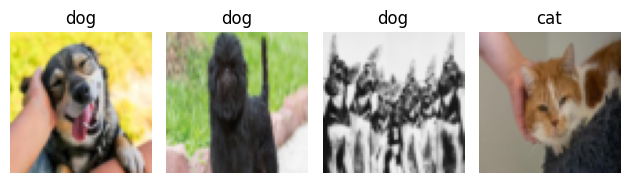

In [64]:
# Extract features/images and targets/labels
dataset_train = CatDogDataset(annotations_file='annotations_train.csv')
dataset_val = CatDogDataset(annotations_file='annotations_val.csv')

# Create data loaders
dataloader_train = DataLoader(dataset_train, batch_size=1000, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=1000, shuffle=False)
# Extract all data from dataloaders
raw_data_train = next(iter(dataloader_train))
raw_data_val = next(iter(dataloader_val))

# Separate features from targets 
raw_features_train = raw_data_train['image'].numpy()
raw_labels_train = raw_data_train['category'].numpy()
raw_features_val = raw_data_val['image'].numpy()
raw_labels_val = raw_data_val['category'].numpy()
# Uncomment 4 lines below to exam the raw data
# print(f"Raw training features shape: {raw_features_train.shape}, raw trainging labels shape: {raw_labels_train.shape}")
# print(f"Raw validation features shape: {raw_features_val.shape}, raw validation labels shape: {raw_labels_val.shape}")
# print(f"A sample of raw features array:\n {raw_features_train[0]}")
# print(f"First 10 raw training labels: {raw_labels_train[:10]}")

# Visualize a few sample images
fig, axs = plt.subplots(1, 4)
for i in range(4):
    sample_img = raw_features_train[i]
    sample_cls = raw_labels_train[i]
    axs[i] = plt.subplot(1, 4, i + 1)
    axs[i].set_title(f'{"dog" if sample_cls == 1. else "cat"}')
    axs[i].axis('off')
    axs[i].imshow(np.transpose(sample_img, (1, 2, 0)))  # image is already in (H, W, C) format
    plt.tight_layout()

# Rerun this cell to get different samples.

### <font color=582C83>(20%) Exercise 1: Data Preprocessing</font>
1. Rescale pixel color intensity values within range: `[0, 1]` using float numbers.
2. Reshape feature array to `(# samples, # pixels)`
3. Reshape label array to `(# samples, 1)`.


In [65]:


### START CODE HERE ### (≈ 4 lines of code)
features_train = raw_features_train.reshape(raw_features_train.shape[0], -1) / 255.
labels_train = raw_labels_train.reshape(-1, 1)
features_val = raw_features_val.reshape(raw_features_val.shape[0], -1) / 255.
labels_val = raw_labels_val.reshape(-1, 1)
### END CODE HERE ###

# Sanity check
print(f"Processed training features shape: {features_train.shape}, a sample:\n {features_train[0]}")
print(f"Processed training labels shape: {labels_train.shape}")
print(f"Processed validation features shape: {features_val.shape}, a sample:\n {features_val[0]}")
print(f"Processed validation labels shape: {labels_val.shape}")


Processed training features shape: (557, 12288), a sample:
 [0.98431373 0.98823529 0.98431373 ... 0.34117647 0.43529412 0.52156863]
Processed training labels shape: (557, 1)
Processed validation features shape: (140, 12288), a sample:
 [0.14509804 0.17647059 0.56862745 ... 0.81176471 0.8        0.79607843]
Processed validation labels shape: (140, 1)


**Expected Output**:
>
```console
Processed training features shape: (557, 30000)
Processed training labels shape: (557, 1)
Processed validation features shape: (140, 30000)
Processed validation labels shape: (140, 1)
```

## 2. Multi-Input Single-Hidden Layer Single-Output Model
$$
\begin{align*}
    \hat{\mathbf{y}} &= \sigma(\mathbf{X}^{[1]} \cdot \mathbf{w}^{[2]T} + b^{[2]}) \\
                     &= \sigma(\sigma(\mathbf{X}^{[0]} \cdot \mathbf{W}^{[1]T} + \mathbf{b}^{[1]}) \cdot \mathbf{w}^{[2]T} + b^{[2]})
\end{align*}
$$

where $\mathbf{X}^{[0]}$ is the input features matrix, $\mathbf{X}^{[1]}$ is the hidden features matrix, and $\hat{\mathbf{y}}$ is model predictions matrix. 
The model is governed by 2 layers of parameters: $\mathbf{W}^{[1]}$, $\mathbf{b}^{[1]}$, $\mathbf{w}^{[2]}$, and $b^{[2]}$. 
$\sigma(\cdot)$ is the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function).
Please refer to lecture [slides](https://linzhanguca.github.io/_docs/deep_learning-2025/0929/nnN11.pdf) for the shape of each matrix/array.

### <font color=#582C83>(5%) Exercise 2: N11 Model Construction </font> 
1. Let the linear model: $\mathbf{Z} = \mathbf{X} \cdot \mathbf{w}^T + b$ to take feature matrix $\mathbf{X}$ as the input and output a transformed/intermediate feature matrix $\mathbf{Z}$.
2. Apply sigmoid function on $\mathbf{Z}$, so that the prediction will be: $\mathbf{\hat{y}} = \sigma(\mathbf{Z}) = 1 / (1 + e^{-\mathbf{Z}})$ 

In [66]:
def sigmoid(in_features):
    """ Sigmoid function
    Args:
        in_features: independent variable, could be an arrary of any shape or a scalar. 
    Returns:
        activated_features: dependent variable, could be an arrary of any shape or a scalar. 
    """
    ### START CODE HERE ### (≈ 1 line of code)
    activated_features = 1 / (1 + np.exp(-in_features))
    ### END CODE HERE ###
    return activated_features

def linear(in_features, weights, biases):
    """ Linear function
    Args:
        in_features: input feature matrix, 2d array with shape (# samples, # input features)
        weights: weight parameter matrix, 2d array with shape (# next layer features , # input features)
        biases: bias parameter vector, 2d array with shape (1, # next layer features)
    Returns:
        linear_output: linear model output feature matrix, 2d array with shape (# samples, # next layer features)
    """
    ### START CODE HERE ### (≈ 2 lines of code)
    linear_output = in_features @ weights.T + biases
    ### END CODE HERE ###
    return linear_output

def forward(in_features, params):
    """ Forward function
    Args:
        in_features: feature matrix, 2d array with shape (# samples, # pixels)
        params: a dictionary of weights and biases
    Returns:
        predictions: predicted probabilities, a column vector or 2d array with shape (# samples, 1)
    """

    ### START CODE HERE ### (≈ 2 lines of code)
    features_1 = sigmoid(linear(in_features, params['W1'], params['b1']))
    predictions = sigmoid(linear(features_1, params['W2'], params['b2']))
    ### END CODE HERE ###
    return predictions, features_1


# Sanity check
np.random.seed(0)
params_dummy = {
    'W1': np.random.normal(size=(5, features_train.shape[1])),
    'b1': np.random.normal(size=(1, 5)),
    'W2': np.random.normal(size=(1, 5)),
    'b2': np.random.normal()
}
preds_dummy, X1_dummy = forward(features_train, params_dummy)
print(f"Hidden layer (X1) shape: {X1_dummy.shape}")
print(f"Hidden layer (X1) samples:\n{X1_dummy[:3]}")
print(f"Shape of dummy predictions: {preds_dummy.shape}")
print(f"Dummy prediction samples:\n{preds_dummy[:3]}")
print(f"Dummy predicted classes samples:\n{(preds_dummy[:3] >= 0.5).astype(int)}")


Hidden layer (X1) shape: (557, 5)
Hidden layer (X1) samples:
[[6.45779918e-35 1.00000000e+00 2.81537648e-30 9.99999991e-01
  1.00000000e+00]
 [3.00519070e-23 1.00000000e+00 6.22272983e-25 1.00000000e+00
  9.99999978e-01]
 [5.50810958e-42 1.00000000e+00 2.73314475e-60 1.00000000e+00
  4.22305644e-06]]
Shape of dummy predictions: (557, 1)
Dummy prediction samples:
[[0.28721663]
 [0.28721663]
 [0.30813225]]
Dummy predicted classes samples:
[[0]
 [0]
 [0]]


**Expected Output**:
>
```console
Hidden layer (X1) shape: (557, 5)
Hidden layer (X1) samples:
[[9.18859355e-45 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00]
 [6.20402875e-16 9.05313419e-37 9.95315864e-01 1.00000000e+00
  1.00000000e+00]
 [3.16542255e-44 9.99999995e-01 1.00000000e+00 1.00000000e+00
  1.00000000e+00]]
Shape of dummy predictions: (557, 1)
Dummy prediction samples:
[[0.56130044]
 [0.33218206]
 [0.56130044]]
Dummy predicted classes samples:
[[1]
 [0]
 [1]]
```

## 3. Evaluate Model

### 3.1. Binary Cross Entropy Loss
$$\mathcal{L}(\mathbf{\hat{y}}, \mathbf{y}) = \frac{1}{M} \Sigma [-\mathbf{y} \log \hat{\mathbf{y}} - (1 - \mathbf{y}) \log(1 - \hat{\mathbf{y}})]$$

### 3.2. Accuracy
$$Acc = \frac{TP + TN}{TP + TN + FP + FN}$$

### <font color=#582c83>(5%) Exercise 3: Model Assessment </font>


In [67]:
def bce_loss(predictions, labels):
    """
    Compute the Binary Cross Entropy (BCE) loss.
    
    Args:
        predictions: model predicted values, a 2d array with shape (# samples, 1)
        labels: labeled values from data set, a 2d array with shape (# samples, 1)
    Returns:
        loss_value: averaged BCE error, a scalar
    """
    ### START CODE HERE ### (≈ 1 line of code)
    loss_value = - np.mean(labels * np.log(predictions) + (1 - labels) * np.log(1 - predictions))
    ### END CODE HERE ###
    return loss_value
    
def accuracy(predictions, labels):
    """
    Compute the accuracy of predictions.
    
    Args:
        predictions: model predicted values, a 2d array with shape (# samples, 1)
        labels: labeled values from data set, a 2d array with shape (# samples, 1)
    Returns:
        acc: accuracy, a scalar
    """
    ### START CODING HERE ### (≈ 2 lines)
    predicted_classes = (predictions >= 0.5).astype(int)
    acc = np.mean(predicted_classes == labels)
    return acc
    ### END CODING HERE ###

# Sanity check
print(f"Dummy model BCE loss: {bce_loss(preds_dummy, labels_train)}")
print(f"Dummy model accuracy: {accuracy(preds_dummy, labels_train) * 100}%")

Dummy model BCE loss: 0.8083909072498442
Dummy model accuracy: 50.08976660682226%


**Expected Output**:
>
```console
Dummy model BCE loss: 0.7303826890071732
Dummy model accuracy: 51.70556552962297%
```

## 4. Back-Propagate Gradients of Loss
Compute gradients of loss so that we can update model parameters later.
$$
\nabla \mathcal{L} = 
\begin{bmatrix} 
    \frac{\partial \mathcal{L}}{\partial \mathbf{W}^{[1]}} &\frac{\partial \mathcal{L}}{\partial \mathbf{b}^{[1]}} &\frac{\partial \mathcal{L}}{\partial \mathbf{w}^{[2]}} &\frac{\partial \mathcal{L}}{\partial b^{[2]}} 
\end{bmatrix} 
$$

The computation of the gradients starts from the last layer, then back-propagate to the first layer. 
$$
\begin{align*}
    \frac{\partial \mathcal{L}}{\partial \mathbf{w}^{[2]}} &= \frac{\partial \mathcal{L}}{\partial \hat{\mathbf{y}}} \frac{\partial \hat{\mathbf{y}}}{\partial \mathbf{Z}^{[2]}} \frac{\partial \mathbf{Z}^{[2]}}{\partial \mathbf{w}^{[2]}} = \frac{1}{M} (\hat{\mathbf{y}} - \mathbf{y})^T \cdot \mathbf{X}^{[1]} \\
    \frac{\partial \mathcal{L}}{\partial b^{[2]}} &= \frac{\partial \mathcal{L}}{\partial \hat{\mathbf{y}}} \frac{\partial \hat{\mathbf{y}}}{\partial \mathbf{Z}^{[2]}} \frac{\partial \mathbf{Z}^{[2]}}{\partial b^{[2]}} = \overline{(\hat{\mathbf{y}} - \mathbf{y})} \\
    \frac{\partial \mathcal{L}}{\partial \mathbf{X}^{[1]}} &= \frac{\partial \mathcal{L}}{\partial \hat{\mathbf{y}}} \frac{\partial \hat{\mathbf{y}}}{\partial \mathbf{Z}^{[2]}} \frac{\partial \mathbf{Z}^{[2]}}{\partial \mathbf{X}^{[1]}} = (\hat{\mathbf{y}} - \mathbf{y}) \cdot \mathbf{w}^{[2]} \\
    \frac{\partial \mathcal{L}}{\partial \mathbf{W}^{[1]}} &= \frac{\partial \mathcal{L}}{\partial \mathbf{X}^{[1]}} \frac{\partial \mathbf{X}^{[1]}}{\partial \mathbf{Z}^{[1]}} \frac{\partial \mathbf{Z}^{[1]}}{\partial \mathbf{W}^{[1]}} = \frac{1}{M} [(\hat{\mathbf{y}} - \mathbf{y}) \cdot \mathbf{w}^{[2]} * \mathbf{X}^{[1]} * (1 - \mathbf{X}^{[1]})]^T \cdot \mathbf{X}^{[0]} \\
    \frac{\partial \mathcal{L}}{\partial \mathbf{b}^{[1]}} &= \frac{\partial \mathcal{L}}{\partial \mathbf{X}^{[1]}} \frac{\partial \mathbf{X}^{[1]}}{\partial \mathbf{Z}^{[1]}} \frac{\partial \mathbf{Z}^{[1]}}{\partial \mathbf{b}^{[1]}} = \overline{(\hat{\mathbf{y}} - \mathbf{y}) \cdot \mathbf{w}^{[2]} * \mathbf{X}^{[1]} * (1 - \mathbf{X}^{[1]})}, axis=0, keepdims
\end{align*}
$$

### <font color=#582c83>(20%) Exercise 4: Gradients Computation</font>



In [68]:
def backward(in_features, features_1, predictions, labels, params):
    """ Gradient function with sigmoid activation
    Args:
        in_features: feature matrix, a 2d array with shape (# samples, # pixels)
        features_1: hidden layer feature matrix, a 2d array with shape (# samples, # hidden features)
        predictions: model predicted value, a 2d array with shape (# samples, 1)
        labels: labeled value from data set, a 2d array with shape (# samples, 1)
        params: a dictionary of weights and biases
    Returns:
        grads: a dictionary of gradients of weights and biases
    """

    ### START CODE HERE ### (≈ 2 lines of code)
    M = labels.shape[0]
    dL_dW2 = (predictions - labels).T @ features_1 / M
    dL_db2 = (predictions - labels).mean()
    dL_dX1 = (predictions - labels) @ params['W2']
    dL_dW1 = (dL_dX1 * features_1 * (1 - features_1)).T @ in_features / M
    dL_db1 = (dL_dX1 * features_1 * (1 - features_1)).mean(axis=0, keepdims=True)
    grads = {
        'dW2': dL_dW2,
        'db2': dL_db2,
        'dW1': dL_dW1,
        'db1': dL_db1
    }   

    return grads
    ### END CODE HERE ### 

grads_dummy = backward(features_train, X1_dummy, preds_dummy, labels_train, params_dummy)
for k, v in grads_dummy.items():
    print(f"{k}: {v}") 
    print(f"Shape of {k}: {v.shape}")   

dW2: [[ 7.69707482e-08 -2.24508525e-01  6.65568000e-05 -1.83000881e-01
  -1.59016053e-01]]
Shape of dW2: (1, 5)
db2: -0.22382182440207865
Shape of db2: ()
dW1: [[ 3.20884715e-11  2.30275819e-11  1.33013781e-11 ... -5.53224794e-11
  -3.59569788e-11 -1.68245213e-11]
 [-1.79765770e-05 -1.85120492e-05 -1.88945222e-05 ... -3.28937236e-06
  -3.36586712e-06 -3.05988196e-06]
 [ 6.52166559e-06  6.32993509e-06  6.32987627e-06 ...  4.79557329e-06
   4.79558695e-06  4.60382703e-06]
 [-1.10363169e-03 -1.10858160e-03 -1.05033304e-03 ... -6.50024373e-04
  -6.43518762e-04 -7.21976113e-04]
 [ 2.11312202e-04  2.16213937e-04  2.17259533e-04 ...  2.40057765e-04
   2.36286339e-04  2.34552924e-04]]
Shape of dW1: (5, 12288)
db1: [[-7.65055098e-08 -1.95247320e-05  4.89170917e-05 -1.80338619e-03
   3.70749703e-04]]
Shape of db1: (1, 5)


**Expected Output**:
>
```console
dW2: [[-0.01461392  0.02354324 -0.06072654 -0.04706703 -0.04498164]]
Shape of dW2: (1, 5)
db2: -0.047067027584174435
Shape of db2: ()
dW1: [[ 2.14505567e-04  2.25592879e-04  2.51128268e-04 ...  1.35455160e-04
   1.27672509e-04  1.18657535e-04]
 [ 4.17031776e-04  4.61204304e-04  3.84073558e-04 ...  2.56606744e-04
   2.20539360e-04  2.35384519e-04]
 [-2.43095608e-05 -1.22165234e-05  8.66212811e-06 ...  3.17481293e-05
   3.34395052e-05  2.70900872e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.29880733e-20  2.06672601e-08  2.06672601e-08 ... -1.02125981e-13
  -7.14881461e-14 -1.53189108e-13]]
Shape of dW1: (5, 30000)
db1: [[ 2.47269617e-04  2.50917557e-04 -9.61591753e-05  1.03531058e-14
   5.27590955e-06]]
Shape of db1: (1, 5)
```

## 5. Update Model Parameters
By tweaking the model parameters along the gradient a small step (learning rate, $\alpha$) iteratively, we expect to bring the model loss down to a reasonable scale.

- Initialize parameters
- Repeat until converge
$$
\begin{align*}
    \mathbf{W}^{[1]} &= \mathbf{W}^{[1]} - \alpha \frac{\partial \mathcal{L}}{\partial \mathbf{W}^{[1]}} \\
    \mathbf{b}^{[1]} &= \mathbf{b}^{[1]} - \alpha \frac{\partial \mathcal{L}}{\partial \mathbf{b}^{[1]}} \\
    \mathbf{w}^{[2]} &= \mathbf{w}^{[2]} - \alpha \frac{\partial \mathcal{L}}{\partial \mathbf{w}^{[1]}} \\
    b^{[2]} &= b^{[2]} - \alpha \frac{\partial \mathcal{L}}{\partial b^{[2]}}
\end{align*}   
$$
### <font color=582c83>(40%) Exercise 5: Model Optimization</font>
1. Define a function to compute gradient of loss
2. Perform gradient descent optimization using appropriate iterations and learning rate.
    1. Initialize weights and bias
    2. Make predictions
    3. Log training loss and test loss
    4. Update weights and bias
    5. Repeat 2 to 5 until converge.
    

In [70]:
# Initialize parameters
params = {
    'W1': np.random.normal(0, 1e-3, size=(128, features_train.shape[1])),
    'b1': np.random.normal(0, 1e-3, size=(1, 128)),
    'W2': np.random.normal(0, 1e-3, size=(1, 128)),
    'b2': np.random.normal(0, 1e-3)
}

# Set hyperparameters
num_iters = 10000
learning_rate = 2e-3

# Reserve metrics storage
losses_train, lossese_val = [], []
accuracies_train, accuracies_val = [], []

# Optimization iterations
for i in range(num_iters):
    # Forward pass
    preds_train, features_1_train = forward(features_train, params)
    preds_val, features_1_val = forward(features_val, params)
    # Compute loss and accuracy
    loss_train = bce_loss(preds_train, labels_train)
    loss_val = bce_loss(preds_val, labels_val)
    acc_train = accuracy(preds_train, labels_train)
    acc_val = accuracy(preds_val, labels_val)
    losses_train.append(loss_train)
    lossese_val.append(loss_val)
    accuracies_train.append(acc_train)
    accuracies_val.append(acc_val)
    # Log progress (every 50 iterations)   
    if i % 50 == 0 or i == num_iters - 1:
        print(f"Iter {i}: Train Loss {loss_train}, Train Acc {acc_train}")
        print(f"Iter {i}: Validation Loss {loss_val}, Validation Acc {acc_val}")
    # Back-propagation
    grads = backward(features_train, features_1_train, preds_train, labels_train, params)
    # Gradient descent parameter update
    params['W1'] = params['W1'] - learning_rate * grads['dW1']
    params['b1'] = params['b1'] - learning_rate * grads['db1']
    params['W2'] = params['W2'] - learning_rate * grads['dW2']
    params['b2'] = params['b2'] - learning_rate * grads['db2']


Iter 0: Train Loss 0.6931572155945083, Train Acc 0.4991023339317774
Iter 0: Validation Loss 0.6931438510796668, Validation Acc 0.5
Iter 50: Train Loss 0.6931509117977723, Train Acc 0.5008976660682226
Iter 50: Validation Loss 0.6931427177838313, Validation Acc 0.5
Iter 100: Train Loss 0.6931489101718334, Train Acc 0.5008976660682226
Iter 100: Validation Loss 0.6931435857646128, Validation Acc 0.5
Iter 150: Train Loss 0.693147731054756, Train Acc 0.5008976660682226
Iter 150: Validation Loss 0.693144269855788, Validation Acc 0.5
Iter 200: Train Loss 0.693146711172618, Train Acc 0.5008976660682226
Iter 200: Validation Loss 0.6931446716779149, Validation Acc 0.5
Iter 250: Train Loss 0.6931457230515655, Train Acc 0.5008976660682226
Iter 250: Validation Loss 0.6931449110842565, Validation Acc 0.5
Iter 300: Train Loss 0.6931447411502246, Train Acc 0.5008976660682226
Iter 300: Validation Loss 0.6931450714477377, Validation Acc 0.5
Iter 350: Train Loss 0.6931437593206871, Train Acc 0.50089766606

Text(0.5, 1.0, 'Confusion Matrix - Validation Data')

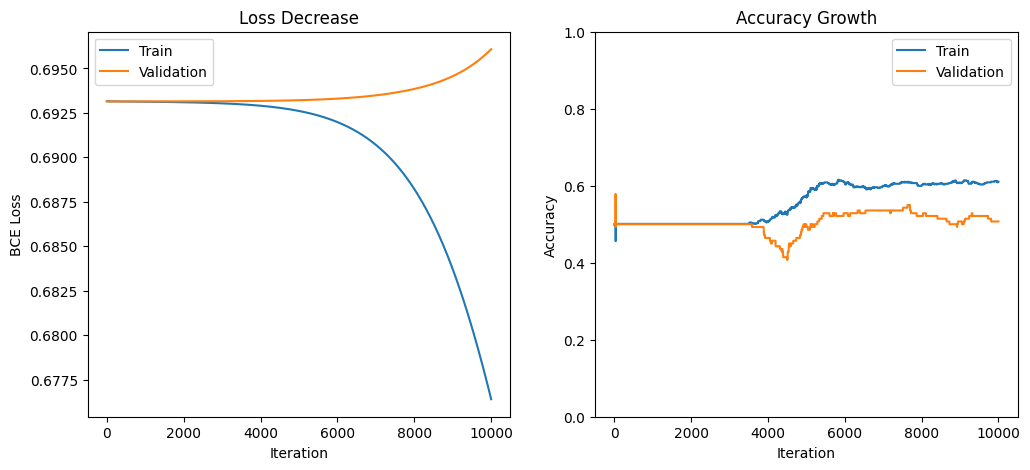

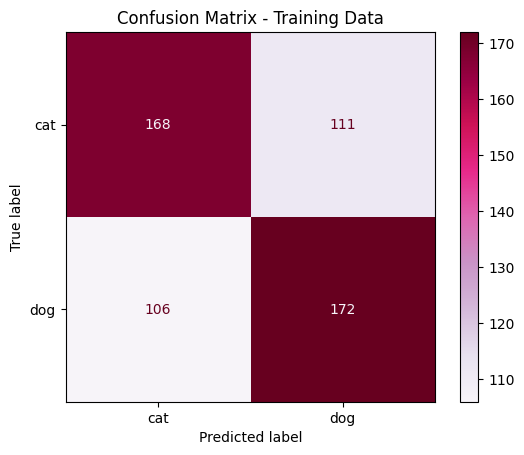

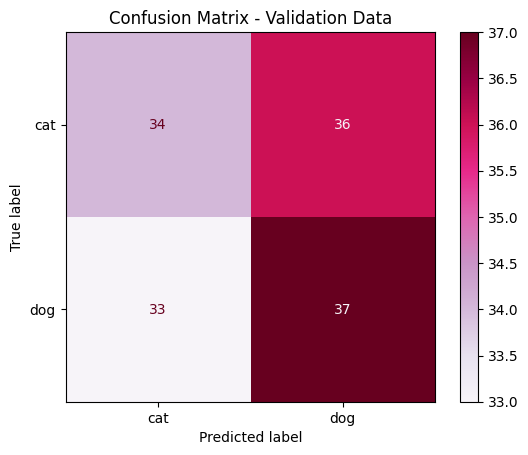

In [71]:

# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_iters), losses_train, range(num_iters), lossese_val)
plt.legend(['Train', 'Validation'])
plt.title("Loss Decrease")
plt.xlabel("Iteration")
plt.ylabel("BCE Loss")
plt.subplot(1, 2, 2)
plt.plot(range(num_iters), accuracies_train, range(num_iters), accuracies_val)
plt.legend(['Train', 'Validation'])
plt.title("Accuracy Growth")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

# Confusion Matrix for Test Data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm_train = confusion_matrix(labels_train, (preds_train >= 0.5).astype(int))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=["cat", "dog"])
disp_train.plot(cmap='PuRd')
plt.title('Confusion Matrix - Training Data')
cm_val = confusion_matrix(labels_val, (preds_val >= 0.5).astype(int))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=["cat", "dog"])
disp_test.plot(cmap='PuRd')
plt.title('Confusion Matrix - Validation Data')

> You may notice the big difference bewteen the prediction accuracy on training data vs. test data. What could be the causes of this phenomenon?

## 6. Test
There are 6 pictures of (3) dogs and (3) cats in this repository. 
Test these new images using the model you've just trained.
Hopefully, all the cats say "Meow" and dogs say "Woof".

### <font color=582c83> (10%) Exercise 6: New Images Test </font>



In [72]:
test_dir = "./test_images"  # locate dataset directory from this repo in the whole system
test_cat_dir = Path(test_dir) / "cats"
test_dog_dir = Path(test_dir) / "dogs"


# Glob test files
test_cat_files = list(test_cat_dir.glob("**/*"))
test_dog_files = list(test_dog_dir.glob("**/*"))
test_files = test_cat_files + test_dog_files

for test_file in test_files:
    image_tensor = decode_image(test_file, mode=ImageReadMode.RGB)
    image = Resize((64, 64))(image_tensor)
    image_np = image.numpy()
    image_flatten = image_np.reshape(1, -1) / 255.
    dog_likelihood, _ = forward(image_flatten, params)
    is_dog = dog_likelihood > 0.5
    if is_dog.squeeze():
        print(f"{test_file.name}: Woof!") 
    else:
        print(f"{test_file.name}: Meow!")



persian.jpg: Meow!
garfield.png: Meow!
tabby.jpg: Meow!
basset.jpg: Meow!
snoopy.png: Meow!
bernese.png: Meow!


# Congratulations! You have finished this assignment!